# Part 1: Casadi 

Building a car simulator considering the tire model using Casadi.  

1. Introduction to CasADi, 

2. Implement nonlinear optimization using Casadi, 


In [1]:
%load_ext autoreload
%autoreload 2
# import sys
# !{sys.executable} -m pip install casadi matplotlib scipy setuptools

In [2]:
import casadi as ca
import numpy as np
import numpy.matlib, scipy
import matplotlib.pyplot as plt
import time

# Introduction to CasADi

CasADi is an open-source tool for nonlinear optimization and algorithmic differentiation.

https://web.casadi.org/

https://web.casadi.org/docs/#what-casadi-is-and-what-it-is-not

<div>
<img src="AD.png" width="800" align="left"/>
</div>


# Why automatic differentiation ? 

In HW1, we derived the **symbolic** Jacobian of bicycle car model.

Automatic differentiation is distinct from **symbolic differentiation** and **numerical differentiation**.

Automatic differentiation exploits the fact that every computer calculation, no matter how complicated, executes a sequence of elementary arithmetic operations (addition, subtraction, multiplication, division, etc.) and elementary functions (exp, log, sin, cos, etc.).

https://en.wikipedia.org/wiki/Automatic_differentiation

## Casadi symbolic framework

### SX

The SX data type is used to represent matrices whose elements consist of symbolic expressions made up by a sequence of unary and binary operations.

### DM

DM is very similar to SX, but with the difference that the nonzero elements are numerical values and not symbolic expressions. The syntax is also the same, except for functions such as SX.sym, which have no equivalents.

### MX

Instead, the elementary operations that are used to form MX expressions are allowed to be general multiple sparse-matrix valued input, multiple sparse-matrix valued output functions. 

In conclusion, SX manipulate each symbolic variable while MX manipulate the entire matrix / vector. 

In [3]:
## SX example

x_SX = ca.SX.sym("x", 3, 2)
y_SX = ca.SX.sym("y", 3, 2)

f = x_SX * 3 + y_SX

print(x_SX)
print(f)
print(f.shape)

## Dense matrix
B1 = ca.SX.zeros(4,5)
print(B1)

## Sparse matrix
B2 = ca.SX(4,5)
print(B2)

## Sparse matrix
B3 = ca.SX.eye(4)
print(B3)


[[x_0, x_3], 
 [x_1, x_4], 
 [x_2, x_5]]
@1=3, 
[[((@1*x_0)+y_0), ((@1*x_3)+y_3)], 
 [((@1*x_1)+y_1), ((@1*x_4)+y_4)], 
 [((@1*x_2)+y_2), ((@1*x_5)+y_5)]]
(3, 2)
@1=0, 
[[@1, @1, @1, @1, @1], 
 [@1, @1, @1, @1, @1], 
 [@1, @1, @1, @1, @1], 
 [@1, @1, @1, @1, @1]]

[[00, 00, 00, 00, 00], 
 [00, 00, 00, 00, 00], 
 [00, 00, 00, 00, 00], 
 [00, 00, 00, 00, 00]]
@1=1, 
[[@1, 00, 00, 00], 
 [00, @1, 00, 00], 
 [00, 00, @1, 00], 
 [00, 00, 00, @1]]


In [4]:
## DM example

C = ca.DM(2, 3)
# C = C + 10

print(C.full())

print(C.sparse())

[[0. 0. 0.]
 [0. 0. 0.]]



In [5]:
## MX example
x_MX = ca.MX.sym('x', 3, 2)
y_MX = ca.MX.sym('y', 3, 2)

print(x_MX)
print(3 * y_MX + x_MX)
print(y_MX * x_MX)
print(y_MX @ x_MX.T)

print(x_MX[0, 1])

x
((3*y)+x)
(y*x)
mac(y,x',zeros(3x3))
x[3]


In [6]:
## Mixing MX and SX
# print(3 * y_SX + x_MX)

### Basic Arithmetic operations

In [7]:
x = ca.SX.sym('x')
y = ca.SX.sym('y',2,2)
print(ca.sin(y)-x)


[[(sin(y_0)-x), (sin(y_2)-x)], 
 [(sin(y_1)-x), (sin(y_3)-x)]]


In [8]:
print(y)
print(y.T)
print(ca.reshape(y, 4, 1))


[[y_0, y_2], 
 [y_1, y_3]]

[[y_0, y_1], 
 [y_2, y_3]]
[y_0, y_1, y_2, y_3]


In [9]:
x = ca.SX.sym('x', 3)
y = ca.SX.sym('y', 3)

print(ca.vertcat(x, y))
print(ca.horzcat(x, y))

[x_0, x_1, x_2, y_0, y_1, y_2]

[[x_0, y_0], 
 [x_1, y_1], 
 [x_2, y_2]]


In [10]:
x = ca.SX.sym('x', 6, 6)

print(x)
print(x[0:3, 0:3])
print(x[0::2, 0::2])


[[x_0, x_6, x_12, x_18, x_24, x_30], 
 [x_1, x_7, x_13, x_19, x_25, x_31], 
 [x_2, x_8, x_14, x_20, x_26, x_32], 
 [x_3, x_9, x_15, x_21, x_27, x_33], 
 [x_4, x_10, x_16, x_22, x_28, x_34], 
 [x_5, x_11, x_17, x_23, x_29, x_35]]

[[x_0, x_6, x_12], 
 [x_1, x_7, x_13], 
 [x_2, x_8, x_14]]

[[x_0, x_12, x_24], 
 [x_2, x_14, x_26], 
 [x_4, x_16, x_28]]


In [11]:
## matrix inner product
x = ca.SX.sym('x', 2, 2)
print(ca.dot(x, x))

(((sq(x_0)+sq(x_1))+sq(x_2))+sq(x_3))


In [12]:
## query property
A = ca.SX.sym('x', 4, 5)
print(A.shape)
print(A.size1())
print(A.size2())

(4, 5)
4
5


### Calculus

$$y = f(x), J:= \frac{\partial f}{\partial x}$$

In [13]:
A = ca.SX.sym('A',3,2)
x = ca.SX.sym('x',2)
print(ca.jacobian(A@x,x))


[[A_0, A_3], 
 [A_1, A_4], 
 [A_2, A_5]]


Gradient for matrix. 

$$f = \langle A, X\rangle, \frac{\partial f}{\partial X} = A$$

In [14]:
## Matrix gradients
print(ca.gradient(ca.dot(A,A),A))


[[(A_0+A_0), (A_3+A_3)], 
 [(A_1+A_1), (A_4+A_4)], 
 [(A_2+A_2), (A_5+A_5)]]


Hessian: 

$$f(x) \approx f(\bar{x}) + \frac{\partial f(x)}{\partial x}|_{x=\bar{x}} + \frac{1}{2}(x - \bar{x})^{T} \frac{\partial^2 f}{\partial^2 x}(x - \bar{x}) $$

In [15]:
## Matrix gradients
[H,g] = ca.hessian(ca.dot(x,x),x)
print('H:', H)

H: @1=2, 
[[@1, 00], 
 [00, @1]]


## Casadi Function Object

### Create custom function

<!-- ### Create integrator

### Solve NLP -->

In [16]:
x = ca.SX.sym('x',2)
y = ca.SX.sym('y')
f = ca.Function('f',[x,y], [x,ca.sin(y)*x])

## define the function
## pay attention to the output
print(f)

## recover the value
f([0., 1], [1])[0].full()

f:(i0[2],i1)->(o0[2],o1[2]) SXFunction


array([[0.],
       [1.]])

### Piece-wise function

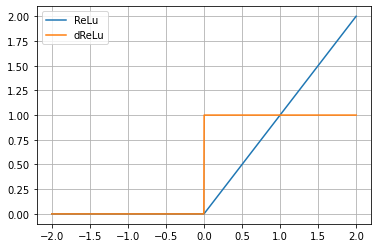

In [17]:
x = ca.SX.sym('x', 1)

Relu = ca.if_else(x>0, 
                  x, 
                  0)
J_Relu = ca.jacobian(Relu, x)

Fun_Relu = ca.Function("ReLu", [x], [Relu])
Fun_Jac_Relu = ca.Function("ReLu", [x], [J_Relu])


x_num = np.linspace(-2, 2, 1000)
y_num = Fun_Relu(x_num)
dy_num = Fun_Jac_Relu(x_num)

plt.plot(x_num, y_num,  label = "ReLu")
plt.plot(x_num, dy_num, label = "dReLu")
plt.grid("on")
plt.legend()

### Creating integrators

$$
\begin{equation}
\begin{aligned}
\dot{x} &= y \\
\dot{y} &= p(1 - x^2)y - x \\
\end{aligned}
\end{equation}
$$

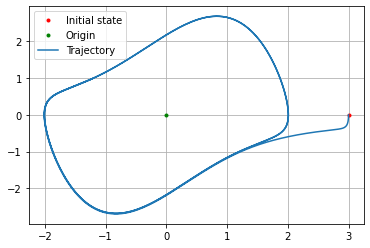

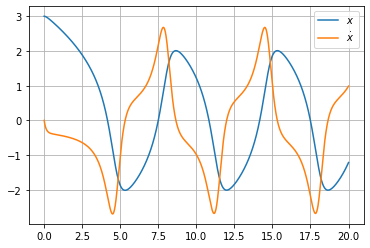

In [18]:
x = ca.SX.sym('x', 2, 1) 
z = ca.SX.sym('z') 

ode = ca.vertcat(  x[1],
                   1. * (1 - x[0]**2) * x[1] - x[0]
                )
dae = {'x':x, 
       'ode':ode, 
       }
Ts = np.linspace(0, 20, 1000)
F = ca.integrator('F', 'cvodes', dae, {'grid':Ts, 'output_t0':True})

x_init = np.array([3, 0])
sol = F(x0 = x_init)

plt.plot(x_init[0], x_init[1], "r.", label = "Initial state")
plt.plot(0.0, 0.0, "g.", label = "Origin")

plt.plot(sol["xf"].full()[0, :], sol["xf"].full()[1, :], label = "Trajectory")
plt.legend()
plt.grid("on")
plt.show()

plt.plot(Ts, sol["xf"].full()[0, :], label = "$x$")
plt.plot(Ts, sol["xf"].full()[1, :], label = "$\dot{x}$")
plt.grid("on")
plt.legend()
plt.show()

### Consider the bicycle car model in HW1. 

Note, the jacobian is obtained by AD, thus not able to extract a symbplic expression. 

In [19]:
h = 0.01
x_model = ca.SX.sym('xm', (4, 1))
u_model = ca.SX.sym('um', (2, 1))
t = ca.SX.sym('t', 1)

L_f = 1.0
L_r = 1.0

beta = ca.atan(L_r / (L_r + L_f) * ca.atan(u_model[1]))

xdot = ca.vertcat(x_model[3] * ca.cos(x_model[2] + beta),
                    x_model[3] * ca.sin(x_model[2] + beta),
                    x_model[3] / L_r * ca.sin(beta),
                    u_model[0])

Fun_dynamics_dt = ca.Function('f_dt', [x_model, u_model], [xdot * h + x_model])
Jac_dynamics_dt = ca.jacobian(xdot * h + x_model, ca.veccat(x_model, u_model))
Fun_Jac_dt = ca.Function('J_dt', [x_model, u_model], [Jac_dynamics_dt])

print(Fun_Jac_dt(np.random.randn(4, 1), np.random.randn(2, 1)))


[[1, 00, 0.00280789, 0.00525236, 00, 0.000349965], 
 [00, 1, -0.00173312, 0.00850956, 00, -0.000216009], 
 [00, 00, 1, 0.00440413, 00, -0.000369229], 
 [00, 00, 00, 1, 0.01, 00]]


We can use the algebraic variable in Casadi to compute the control variables in the simulation

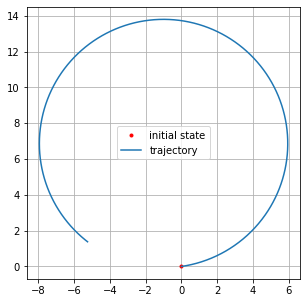

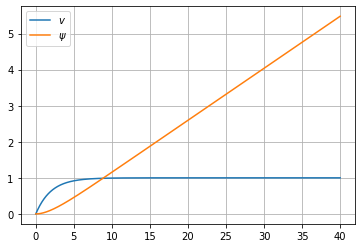

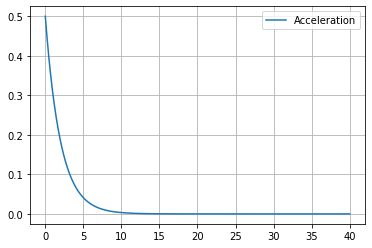

In [20]:
dae = {'x':x_model, 
       't':t,
       'p':u_model[1],
       'z':u_model[0],
       'alg': ca.vertcat(0.5 * (1 - x_model[3]) - u_model[0], ), 
       'ode':xdot, 
       }
Ts = np.linspace(0, 40, 1000)
F = ca.integrator('F', 'idas', dae, {'grid':Ts, 'output_t0':True})

x_init = np.array([0, 0, 0, 0])
sol = F(x0 = x_init, p = np.array([0.3]))

plt.figure(figsize=(5, 5))
plt.plot(x_init[0], x_init[1], "r.", label = "initial state")
plt.plot(sol["xf"].full()[0, :], sol["xf"].full()[1, :], label = "trajectory")
plt.legend()
plt.axis("scaled")
plt.grid("on")
plt.show()

plt.plot(Ts, sol["xf"].full()[3, :], label = "$v$")
plt.plot(Ts, sol["xf"].full()[2, :], label = "$\psi$")
plt.legend()
plt.grid("on")
plt.show()

plt.plot(Ts, sol["zf"].full()[0, :], label = "Acceleration")
plt.legend()
plt.grid("on")
plt.show()

### 1-D interpolation

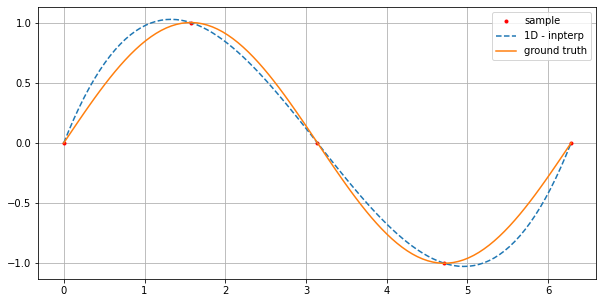

In [21]:
x = np.linspace(0, np.pi * 2, 5)
y = np.sin(x)

lookuptable = ca.interpolant("LUT", "bspline", [x], y)

plt.figure(figsize=(10, 5))
plt.plot(x, y, "r.", label = "sample")
x = np.linspace(0, np.pi * 2, 100)

plt.plot(x, lookuptable(x), "--", label = "1D - inpterp")
plt.plot(x, np.sin(x),  "-",  label = "ground truth")

plt.legend()
plt.grid("on")

# Optimization

Casadi support nonlinear programming of the following form:

$$
\begin{equation}
\begin{aligned}

J = &\min_{x} f(x, p) \\
 \quad & lb_g \le g(x, p) \le ub_g \\
 \quad & lb_x \le x \le ub_x
\end{aligned}
\end{equation}
$$

with:

$$x\in \mathbb{R}^n, g\in \mathbb{R}^m, p \in \mathbb{R}^q$$

In [22]:
opti = ca.Opti()

x = opti.variable()
y = opti.variable()

opti.minimize(  (y-x**2)**2   )
opti.subject_to( x**2+y**2==1 )
opti.subject_to(       x+y>=1 )

opti.solver('ipopt')


sol = opti.solve()

print(sol.value(x))
print(sol.value(y))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

In [23]:
## define varaible
x = ca.MX.sym('x', (2, 1))

## define parameters
p = ca.MX.sym('p', (2, 1))

## define objective function
J = (x[0] - p[0])**2 + (x[1] - p[1])**2

## define constraints
## lb <= G(x) <= ub
cons_NLP = [(x[0] - 1)**2,
            x[1]]
cons_NLP = ca.vertcat(*cons_NLP)

## define problem
prob = {"x": x, "p":p, "f": J, "g":cons_NLP}

## define solver
opts = {'ipopt.print_level': 0, 'print_time': 0} # , 'ipopt.sb': 'yes'}
solver = ca.nlpsol('solver', 'ipopt', prob , opts)


## get the numbers
lb_var = np.array([-1000, -1000])
ub_var = np.array([1000, 1000])

lb_cons = np.array([-10, -10])
ub_cons = np.array([10, 10])

x0_nlp = np.array([-10, 10])
lamx0_nlp = np.array([-0, 0])
lamg0_nlp = np.array([-0, 0])
par_nlp = np.array([1, 1])

sol = solver(x0=x0_nlp, lam_x0=lamx0_nlp, lam_g0=lamg0_nlp,
                     lbx=lb_var, ubx=ub_var, lbg=lb_cons, ubg=ub_cons, p = par_nlp)

sol

{'f': DM(6.40848e-022),
 'g': DM([6.52043e-030, 1]),
 'lam_g': DM([1.05879e-022, 5.0625e-011]),
 'lam_p': DM([-5.10703e-015, -5.06299e-011]),
 'lam_x': DM([5.01181e-015, 5.01188e-015]),
 'x': DM([1, 1])}

## Nonlinear MPC example

### Consider the dubin car model for motion generation

$$
\begin{equation}
\begin{aligned}
\dot{x} &= v \cos(\theta) \\
\dot{y} &= v \sin(\theta) \\
\dot{\theta} &= w \\
\dot{v} &= a \\
\end{aligned}
\end{equation}
$$

In [24]:
T = 4.
N = 40

h = T / N
Dim_ctrl =  2
Dim_state = 4

In [25]:
xm = ca.MX.sym("xm", (Dim_state, 1))
um = ca.MX.sym("um", (Dim_ctrl , 1))

xdot = ca.vertcat(
    xm[3] * ca.cos(xm[2]),
    xm[3] * ca.sin(xm[2]),
    um[0],
    um[1]
)

Fun_dynamics_dt = ca.Function('f_dt', [xm, um], [xdot * h + xm])

In [26]:
state_ub = np.array([ 1e4,  1e4,  1e4,  1e4])
state_lb = np.array([-1e4, -1e4, -1e4, -1e4])
ctrl_ub  = np.array([ 1,  1])
ctrl_lb  = np.array([-1, -1])

# upper bound and lower bound
ub_x = np.matlib.repmat(state_ub, N + 1, 1)
lb_x = np.matlib.repmat(state_lb, N + 1, 1)

ub_u = np.matlib.repmat(ctrl_ub, N, 1)
lb_u = np.matlib.repmat(ctrl_lb, N, 1)

ub_var = np.concatenate((ub_u.reshape((Dim_ctrl * N, 1)), ub_x.reshape((Dim_state * (N+1), 1))))
lb_var = np.concatenate((lb_u.reshape((Dim_ctrl * N, 1)), lb_x.reshape((Dim_state * (N+1), 1))))

In [27]:
# Declare model variables
x = ca.MX.sym('x', (Dim_state, N + 1))
u = ca.MX.sym('u', (Dim_ctrl , N))
p = ca.MX.sym('p', (Dim_state, 1))

# dynamics constraints
cons_dynamics = []
ub_dynamics = np.zeros((N * Dim_state, 1))
lb_dynamics = np.zeros((N * Dim_state, 1))
for k in range(N):
    Fx = Fun_dynamics_dt(x[:, k], u[:, k])
    for j in range(Dim_state):
        cons_dynamics.append(x[j, k+1] -  Fx[j])

# state constraints: G(x) <= 0
alpha = 0.9
cons_state = []
for k in range(N):
    # cons_state.append( 9 - ((x[0, k] - 4)**2 + (x[1, k] - 4)**2) )
    Bk   = 9 - ((x[0, k] - 4)**2 + (x[1, k] - 4)**2)
    Bkp1 = 9 - ((x[0, k+1] - 4)**2 + (x[1, k+1] - 4)**2)

    ## discrete time control barrier function
    cons_state.append( Bkp1 - alpha* Bk )
    # cons_state.append( 9 - ((x[0, k] - 4)**2 + (x[1, k] - 4)**2) )

ub_state_cons = np.zeros((len(cons_state), 1))
lb_state_cons = np.zeros((len(cons_state), 1)) - 1e5

# cost function: 
J = 100 * ((x[0, -1] - 10)**2 + (x[1, -1] - 10)**2)  + 100 * x[2, -1]**2 + 100 * x[3, -1]**2
for k in range(N):
    J = J + 10 * ((x[0, k] - 10)**2 + (x[1, k] - 10)**2) + 10 * x[2, k]**2 + 10 * x[3, k]**2
    J = J + 1 * (u[0, k]**2 + u[1, k]**2)

# initial constraints
cons_init = [x[:, 0] - p]
lb_init_cons = np.zeros((Dim_state, 1))
ub_init_cons = np.zeros((Dim_state, 1))

vars_NLP   = ca.vertcat(u.reshape((Dim_ctrl * N, 1)), x.reshape((Dim_state * (N+1), 1)))
cons_NLP = cons_dynamics + cons_state + cons_init
cons_NLP = ca.vertcat(*cons_NLP)
lb_cons = np.concatenate((lb_dynamics, lb_state_cons, lb_init_cons))
ub_cons = np.concatenate((ub_dynamics, ub_state_cons, ub_init_cons))

n_x = vars_NLP.shape[0]
n_g = cons_NLP.shape[0]

# Create an NLP solver
prob = {"x": vars_NLP, "p":p, "f": J, "g":cons_NLP}
opts = {'ipopt.print_level': 0, 'print_time': 0} # , 'ipopt.sb': 'yes'}
solver = ca.nlpsol('solver', 'ipopt', prob , opts)

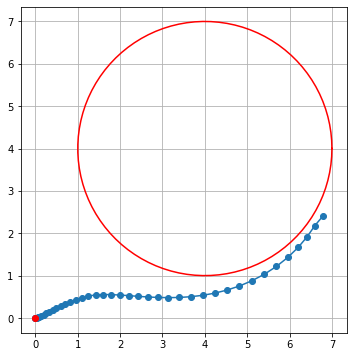

In [28]:
x0_nlp    = np.random.randn(n_x, 1) * 0
lamx0_nlp = np.random.randn(n_x, 1) * 0
lamg0_nlp = np.random.randn(n_g, 1) * 0

par_nlp = np.array([0, 0, 0, 0])# np.random.randn(Dim_state, 1)

sol = solver(x0=x0_nlp, lam_x0=lamx0_nlp, lam_g0=lamg0_nlp,
                     lbx=lb_var, ubx=ub_var, lbg=lb_cons, ubg=ub_cons, p = par_nlp)

x = sol["x"].full()[N*Dim_ctrl:]

plt.figure(figsize=(6, 6))
plt.plot(x[0::Dim_state], x[1::Dim_state], "-o")
plt.plot(x[0], x[1], "ro")
plt.plot(3 * np.cos(np.linspace(0, np.pi*2, 100)) + 4, 3 * np.sin(np.linspace(0, np.pi*2, 100)) + 4, "r")
plt.axis('scaled')
plt.grid("on")

In [29]:
N_sim = 400
x_log = np.zeros((N_sim + 1, Dim_state))
u_log = np.zeros((N_sim, Dim_ctrl))

x0_nlp    = np.zeros((n_x, 1))
lamx0_nlp = np.zeros((n_x, 1))
lamg0_nlp = np.zeros((n_g, 1))

x_log[0, :] = np.array([0, 0, 0, 0])

N_test = N_sim
for k in range(N_test):# range(N_sim):
    
    par_nlp = x_log[k, :]
    
    sol = solver(x0=x0_nlp, lam_x0=lamx0_nlp, lam_g0=lamg0_nlp,
                     lbx=lb_var, ubx=ub_var, lbg=lb_cons, ubg=ub_cons, p = par_nlp)

    x0_nlp = sol["x"].full()
    lamx0_nlp = sol["lam_x"].full()
    lamg0_nlp = sol["lam_g"].full()
    
    uk = sol["x"].full()[0:Dim_ctrl]
    xkp1 = Fun_dynamics_dt(x_log[k, :], uk)

    x_log[k + 1, :] = np.squeeze(xkp1)
    u_log[k, :]     = np.squeeze(uk)

x = sol["x"].full()[N*Dim_ctrl:]

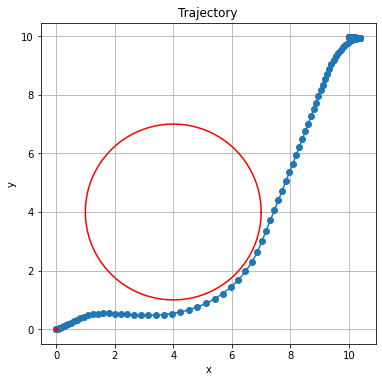

In [30]:
plt.figure(figsize=(6, 6))
plt.plot(x_log[:, 0], x_log[:, 1], "-o")
plt.plot(x_log[0, 0], x_log[0, 1], "r.")
plt.plot(3 * np.cos(np.linspace(0, np.pi*2, 100)) + 4, 3 * np.sin(np.linspace(0, np.pi*2, 100)) + 4, "r")

plt.title("Trajectory")
plt.ylabel("y")
plt.xlabel("x")
plt.axis('scaled')
plt.grid("on")

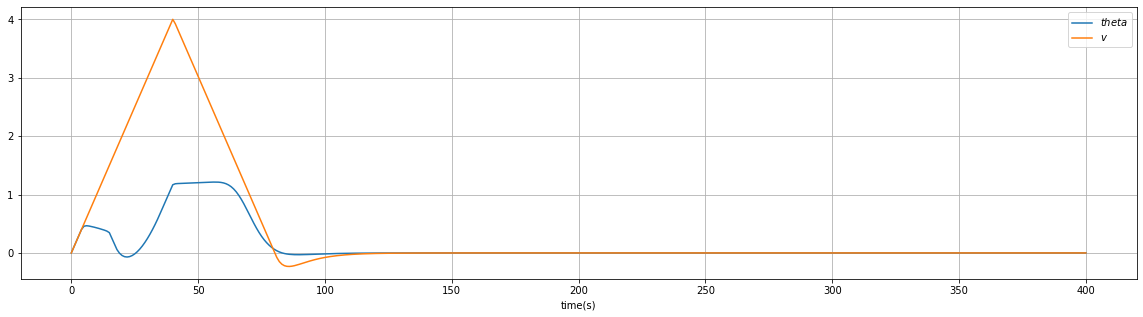

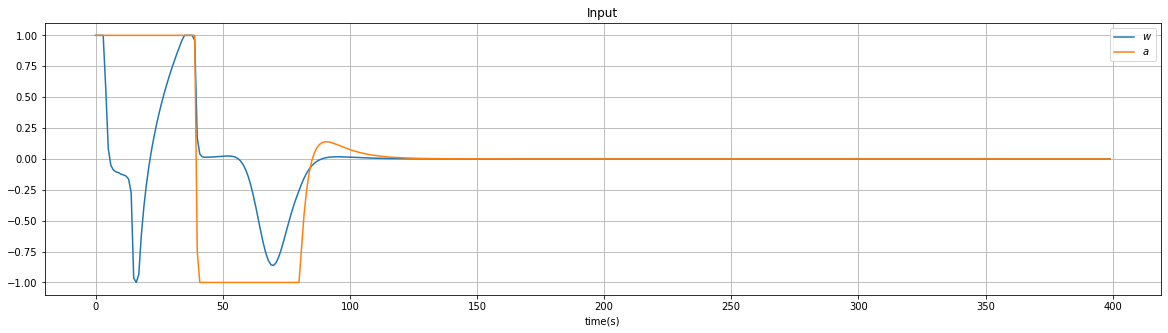

In [31]:
plt.figure(figsize=(20, 5))
plt.plot(x_log[:, 2], label = "$theta$")
plt.plot(x_log[:, 3], label = "$v$")
plt.legend()
plt.grid("on")
plt.xlabel("time(s)")
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(u_log[:, 0], label = "$w$")
plt.plot(u_log[:, 1], label = "$a$")
plt.title("Input")
plt.legend()
plt.grid("on")
plt.xlabel("time(s)")
plt.show()